## Topic:        Challenge Set 1  
Subject:      Explore MTA turnstile data  
Date:         09/28/2019  
Name:         Vicky Su  
Worked with:     
Location:     SF   

In [14]:
import sys
print("Python Version:", sys.version)

Python Version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
#Setup
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

### Challenge 1
Open up a new IPython notebook
Download a few MTA turnstile data files
Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like
{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'], ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'], ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'], ... ] }

In [3]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_190928.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.6M    0 25.6M    0     0  5288k      0 --:--:--  0:00:04 --:--:-- 5668k


In [4]:
import csv
data = []
with open ('turnstile_190928.txt','r') as csvfile:
    reader = csv.reader(csvfile)
    data = [[x.strip() for x in row] for row in reader]

In [5]:
data.pop(0) #pop the column

['C/A',
 'UNIT',
 'SCP',
 'STATION',
 'LINENAME',
 'DIVISION',
 'DATE',
 'TIME',
 'DESC',
 'ENTRIES',
 'EXITS']

In [6]:
raw_readings = {}
for line in data:
    raw_readings.setdefault(tuple(line[:4]), []).append(tuple(line[4:]))

In [7]:
# list(raw_readings.items())[0]

### Challenge 2

Let's turn this into a time series.
For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil module to convert it into a datetime object. For an example check this StackOverflow question.

Your new dict should look something like

{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ [datetime.datetime(2013, 3, 2, 3, 0), 3788], [datetime.datetime(2013, 3, 2, 7, 0), 2585], [datetime.datetime(2013, 3, 2, 12, 0), 10653], [datetime.datetime(2013, 3, 2, 17, 0), 11016], [datetime.datetime(2013, 3, 2, 23, 0), 10666], [datetime.datetime(2013, 3, 3, 3, 0), 10814], [datetime.datetime(2013, 3, 3, 7, 0), 10229], ... ], .... }

In [8]:
from datetime import datetime

def new_value(value):
    date = value[2].split('/')
    time = value[3].split(':')
    Entries = value[5]
    date_conv = datetime(int(date[2]),int(date[0]),int(date[1]),int(time[0]),int(time[1]),int(time[2]))
    return [date_conv, int(Entries)]

new_dict = {}
for key, value_ls in raw_readings.items():

    for value in value_ls:        
        new_dict.setdefault(key,[]).append(new_value(value))


In [9]:
# new_dict[('A002','R051','02-00-00','59 ST')]

## Challenge 3
These counts are for every n hours. (What is n?) We want total daily entries.
Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [24]:
data_ls = list(new_dict.items())
# data_ls = data_ls[0:2]
# data_ls

In [42]:
data_ls = list(new_dict.items())
data_ls = data_ls
new_dict2 = {}

for row in data_ls:
    
    SUM = 0 
    past = row[1][0][0].date()
    
    for value in row[1]:

        present = value[0].date()
#         print(value, present)
        if past == present:
            SUM += value[1]
#             print(value, present, SUM)
        else:
            new_dict2.setdefault(row[0],[]).append([present, SUM])
            SUM = 0
        past = present
        

In [26]:
# new_dict2[('A002','R051','02-00-00','59 ST')]

## Challenge 4

We will plot the daily time series for __a__ turnstile.

In ipython notebook, add this to the beginning of your next cell:

`%matplotlib inline`
This will make your matplotlib graphs integrate nicely with the notebook. To plot the time series, import matplotlib with

`import matplotlib.pyplot as plt`
Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:

`plt.figure(figsize=(10,3))`
`plt.plot(dates,counts)`

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
one_turnstile = list(new_dict2.items())[14] #random Turnstile
x = one_turnstile[1]
x =x[1:]


[31398771, 31402893, 31409582, 31417032, 31424268]
[datetime.date(2019, 9, 23), datetime.date(2019, 9, 24), datetime.date(2019, 9, 25), datetime.date(2019, 9, 26), datetime.date(2019, 9, 27)]


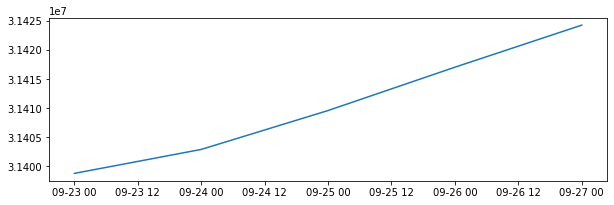

In [53]:
dates = []
counts = []

for data in x:
    dates.append(data[0])
    counts.append(data[1])

print(counts)
print(dates)
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

## Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.
We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [54]:
import pandas as pd  #how to split a series 
df = pd.read_csv('turnstile_190928.txt')
df_new = df.groupby(['C/A','UNIT','STATION','DATE']).ENTRIES.agg('sum').reset_index()
df_new

,C/A,UNIT,STATION,DATE,ENTRIES
0,A002,R051,59 ST,09/21/2019,338864648
1,A002,R051,59 ST,09/22/2019,338909014
2,A002,R051,59 ST,09/23/2019,338956489
3,A002,R051,59 ST,09/24/2019,339036685
4,A002,R051,59 ST,09/25/2019,339120702
...,...,...,...,...,...
5200,TRAM2,R469,RIT-ROOSEVELT,09/23/2019,44421779
5201,TRAM2,R469,RIT-ROOSEVELT,09/24/2019,44442295
5202,TRAM2,R469,RIT-ROOSEVELT,09/25/2019,44462966
5203,TRAM2,R469,RIT-ROOSEVELT,09/26/2019,44483672


## Challenge 6
Similarly, combine everything in each station, and come up with a time series of `[(date1, count1),(date2,count2),...]` type of time series for each STATION, by adding up all the turnstiles in a station.

In [55]:
df_new2 = df.groupby(['STATION','DATE']).ENTRIES.agg('sum').reset_index()
df_new2

,STATION,DATE,ENTRIES
0,1 AV,09/21/2019,8492323173
1,1 AV,09/22/2019,8492358476
2,1 AV,09/23/2019,8492412211
3,1 AV,09/24/2019,8947825570
4,1 AV,09/25/2019,8492630953
...,...,...,...
2637,ZEREGA AV,09/23/2019,12751396
2638,ZEREGA AV,09/24/2019,12768954
2639,ZEREGA AV,09/25/2019,12786515
2640,ZEREGA AV,09/26/2019,12803286


## Challenge 7
plot the time series for a station

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

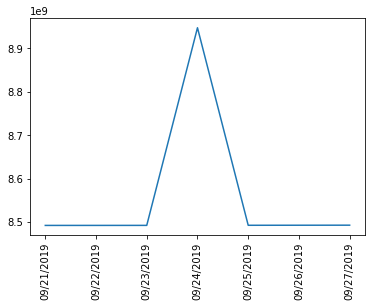

In [56]:
df_new3 = df.groupby(['STATION','DATE']).ENTRIES.agg('sum').reset_index()
plt.plot(df_new3[df_new3.STATION == '1 AV'].DATE, df_new3[df_new3.STATION == '1 AV'].ENTRIES)
plt.xticks(rotation = 90)

## Challenge 8
Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [57]:
df_new3[df_new3.STATION == '1 AV']

,STATION,DATE,ENTRIES
0,1 AV,09/21/2019,8492323173
1,1 AV,09/22/2019,8492358476
2,1 AV,09/23/2019,8492412211
3,1 AV,09/24/2019,8947825570
4,1 AV,09/25/2019,8492630953
5,1 AV,09/26/2019,8492747986
6,1 AV,09/27/2019,8492864383


## Challenge 9
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

## Challenge 10
Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

In [63]:
X = df_new3.groupby('STATION').ENTRIES.sum().reset_index().STATION
Y = df_new3.groupby('STATION').ENTRIES.sum().reset_index().ENTRIES

([<matplotlib.axis.XTick at 0x119617b70>,
 <a list of 378 Text xticklabel objects>)

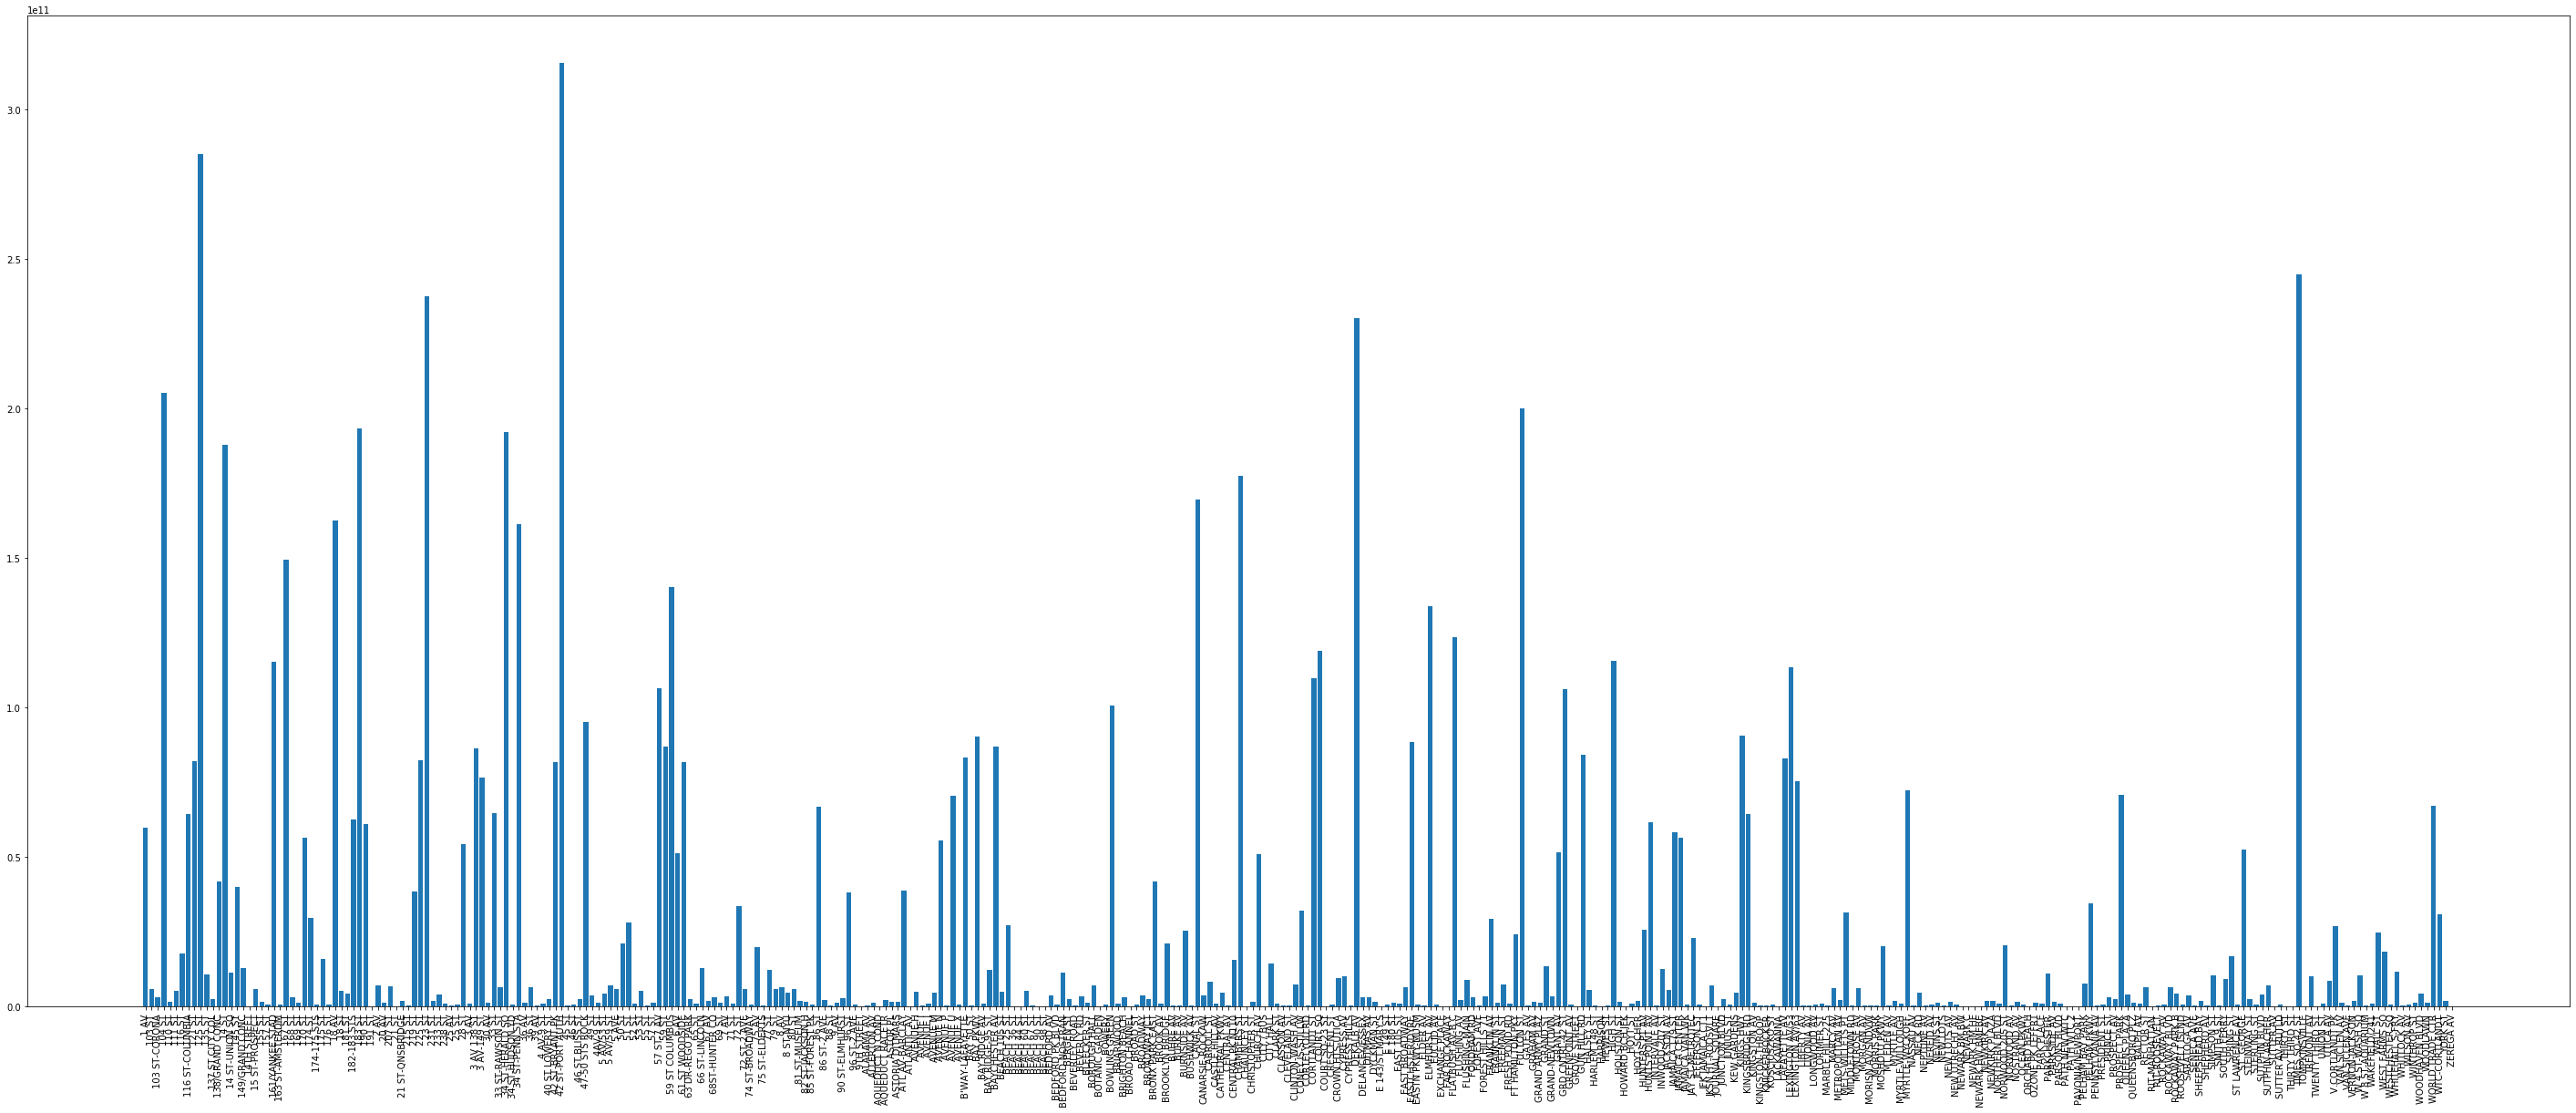

In [64]:
plt.figure(figsize = [50,20])
plt.bar(X,Y);
# plt.xticks(X, rotation = 90)

plt.xticks(ticks =X, labels = list(X), rotation = 90)